In [1]:
import sklearn
import pandas as pd
import numpy as np
import nltk
import random
import sklearn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
import matplotlib
from sklearn.model_selection import cross_val_score
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import train_test_split
import re
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
np.random.seed(500)
Corpus = pd.read_csv(r"../input_data/drugs/labelled_drugs.csv",encoding='latin-1', skiprows=[227225])
Corpus = Corpus.rename({'drugs_report_content':'text', 'drugs_answer_label': 'label'}, axis=1)
Corpus['text'] = Corpus['text'].str.replace('\t',' ')
Corpus.drop(['Unnamed: 0'], axis=1, inplace=True)
Corpus.drop_duplicates(inplace=True)
Corpus['text'] = Corpus['text'].astype(str)

In [3]:
# Preprocessing
stemmer = SnowballStemmer("dutch")
Corpus['text'] = Corpus['text'].str.lower()
Corpus['text'] = [stemmer.stem(text) for text in Corpus['text']]
Corpus['label'] = Corpus['label'].str.replace('Niets gevonden','Nee')
Corpus = Corpus.drop(Corpus[Corpus.label == '--'].index)
Corpus_backup = Corpus.copy()

In [4]:
stopwords_filter = ['niet', 'niets', 'geen', 'zonder']
with open('../helping_files/stopwords.txt') as file:
    full_stopwords = [line.rstrip() for line in file]
    filtered_stopwords = [item for item in full_stopwords if item not in stopwords_filter]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(Corpus['text'], Corpus['label'], test_size=0.2, random_state=50)

# Multinomial Naive Bayes

In [10]:
class_priors = [list(item) for item in list(np.random.dirichlet(np.ones(2), size=5))]
parameter_grid = {
                  'clf__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  'clf__fit_prior': [True, False],
                  'clf__class_prior': random.sample(class_priors, k=len(class_priors)),
                  'tfidf__max_df': [0.90, 0.95],
                  'tfidf__min_df': [3, 5]
                 }

# Only negation stopwords kept

In [11]:
no_stopwords = lambda x: ' '.join([item for item in x.split() if item not in full_stopwords])
less_stopwords = lambda x: ' '.join([item for item in x.split() if item not in filtered_stopwords])

Corpus["text"] = Corpus["text"].apply(less_stopwords)
X_train, X_test, y_train, y_test = train_test_split(Corpus['text'], Corpus['label'], test_size=0.2, random_state=50)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END clf__alpha=0.001, clf__class_prior=[0.026158365516680847, 0.9738416344833192], clf__fit_prior=True, tfidf__max_df=0.95, tfidf__min_df=3;, score=0.539 total time=  28.6s
[CV 2/5] END clf__alpha=0.001, clf__class_prior=[0.026158365516680847, 0.9738416344833192], clf__fit_prior=True, tfidf__max_df=0.95, tfidf__min_df=3;, score=0.531 total time=  25.3s
[CV 3/5] END clf__alpha=0.001, clf__class_prior=[0.026158365516680847, 0.9738416344833192], clf__fit_prior=True, tfidf__max_df=0.95, tfidf__min_df=3;, score=0.534 total time=  25.9s
[CV 4/5] END clf__alpha=0.001, clf__class_prior=[0.026158365516680847, 0.9738416344833192], clf__fit_prior=True, tfidf__max_df=0.95, tfidf__min_df=3;, score=0.534 total time=  26.6s
[CV 5/5] END clf__alpha=0.001, clf__class_prior=[0.026158365516680847, 0.9738416344833192], clf__fit_prior=True, tfidf__max_df=0.95, tfidf__min_df=3;, score=0.536 total time=  32.5s
[CV 1/5] END clf__alpha=10, c

[CV 2/5] END clf__alpha=0.001, clf__class_prior=[0.026158365516680847, 0.9738416344833192], clf__fit_prior=False, tfidf__max_df=0.95, tfidf__min_df=5;, score=0.530 total time=  19.2s
[CV 3/5] END clf__alpha=0.001, clf__class_prior=[0.026158365516680847, 0.9738416344833192], clf__fit_prior=False, tfidf__max_df=0.95, tfidf__min_df=5;, score=0.533 total time=  18.7s
[CV 4/5] END clf__alpha=0.001, clf__class_prior=[0.026158365516680847, 0.9738416344833192], clf__fit_prior=False, tfidf__max_df=0.95, tfidf__min_df=5;, score=0.533 total time=  18.7s
[CV 5/5] END clf__alpha=0.001, clf__class_prior=[0.026158365516680847, 0.9738416344833192], clf__fit_prior=False, tfidf__max_df=0.95, tfidf__min_df=5;, score=0.535 total time=  19.4s
0.8955743243243244


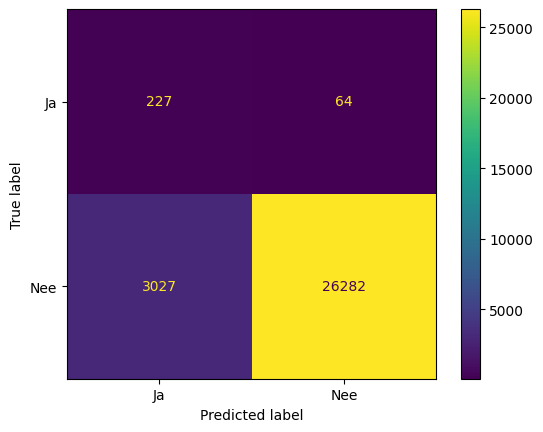

              precision    recall  f1-score   support

          Ja       0.07      0.78      0.13       291
         Nee       1.00      0.90      0.94     29309

    accuracy                           0.90     29600
   macro avg       0.53      0.84      0.54     29600
weighted avg       0.99      0.90      0.94     29600



In [12]:
# Ngram 1 Less stopwords
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1), lowercase=True, token_pattern=r"(?u)\b\w\w+\b|\+|\-")),
    ('clf', MultinomialNB()),
])
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameter_grid, random_state=500, verbose=3, scoring='f1_macro')
random_search.fit(X_train, y_train)  
predicted_nb = random_search.predict(X_test)
print(np.mean(predicted_nb == y_test))
cm = confusion_matrix(y_test, predicted_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=random_search.classes_)
disp.plot()

plt.show()
print(metrics.classification_report(y_test, predicted_nb,
    target_names=random_search.classes_))

# Stochastic Gradient Descent

In [6]:
# RESET CORPUS
Corpus = Corpus_backup.copy()
X_train, X_test, y_train, y_test = train_test_split(Corpus['text'], Corpus['label'], test_size=0.2, random_state=50)

In [7]:
parameter_grid = {'clf__loss':              ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                  'clf__penalty':           ['l2', 'l1'],
                  'clf__l1_ratio':          sp_randFloat(),
                  'clf__fit_intercept':     [True, False],
                  'clf__max_iter':          [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                  'clf__tol':               sp_randFloat(),
                  'clf__shuffle':           [True, False],
                  'clf__epsilon':           sp_randFloat(),
                  'clf__learning_rate':     ['constant', 'optimal', 'invscaling', 'adaptive'],
                  'clf__eta0':              sp_randFloat(),
                  'clf__power_t':           sp_randFloat(),
                  'clf__class_weight':      ['balanced', None],
                  'clf__warm_start':        [True, False],
                  'clf__average':           [True, False],
                  'tfidf__max_df':          [0.90, 0.95],
                  'tfidf__min_df':          [3, 5]
                 }

# Stopwords kept

Fitting 5 folds for each of 10 candidates, totalling 50 fits
-- Epoch 1
Norm: 82.52, NNZs: 242, Bias: 0.000000, T: 71040, Avg. loss: 0.072852
Total training time: 0.49 seconds.
-- Epoch 2
Norm: 111.05, NNZs: 92, Bias: 0.000000, T: 142080, Avg. loss: 0.050355
Total training time: 1.04 seconds.
-- Epoch 3
Norm: 132.94, NNZs: 68, Bias: 0.000000, T: 213120, Avg. loss: 0.044303
Total training time: 1.73 seconds.
-- Epoch 4
Norm: 151.11, NNZs: 60, Bias: 0.000000, T: 284160, Avg. loss: 0.041143
Total training time: 2.52 seconds.
-- Epoch 5
Norm: 167.17, NNZs: 54, Bias: 0.000000, T: 355200, Avg. loss: 0.039291
Total training time: 3.23 seconds.
-- Epoch 6
Norm: 181.54, NNZs: 50, Bias: 0.000000, T: 426240, Avg. loss: 0.037485
Total training time: 3.88 seconds.
-- Epoch 7
Norm: 184.16, NNZs: 49, Bias: 0.000000, T: 497280, Avg. loss: 0.036878
Total training time: 4.62 seconds.
-- Epoch 8
Norm: 186.76, NNZs: 49, Bias: 0.000000, T: 568320, Avg. loss: 0.036666
Total training time: 5.37 seconds.
-- E

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.198 total time= 1.4min
-- Epoch 1
Norm: 82.25, NNZs: 260, Bias: 0.000000, T: 71040, Avg. loss: 0.073303
Total training time: 0.52 seconds.
-- Epoch 2
Norm: 110.87, NNZs: 90, Bias: 0.000000, T: 142080, Avg. loss: 0.050579
Total training time: 1.09 seconds.
-- Epoch 3
Norm: 132.56, NNZs: 68, Bias: 0.000000, T: 213120, Avg. loss: 0.044778
Total training time: 1.67 seconds.
-- Epoch 4
Norm: 150.85, NNZs: 59, Bias: 0.000000, T: 284160, Avg. loss: 0.041464
Total training time: 2.29 seconds.
-- Epoch 5
Norm: 166.83, NNZs: 54, Bias: 0.000000, T: 355200, Avg. loss: 0.039263
Total training 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.195 total time= 1.4min
-- Epoch 1
Norm: 81.64, NNZs: 245, Bias: 0.000000, T: 71040, Avg. loss: 0.074410
Total training time: 0.50 seconds.
-- Epoch 2
Norm: 110.52, NNZs: 93, Bias: 0.000000, T: 142080, Avg. loss: 0.051461
Total training time: 1.14 seconds.
-- Epoch 3
Norm: 132.35, NNZs: 68, Bias: 0.000000, T: 213120, Avg. loss: 0.045226
Total training time: 1.80 seconds.
-- Epoch 4
Norm: 150.66, NNZs: 58, Bias: 0.000000, T: 284160, Avg. loss: 0.041856
Total training time: 2.94 seconds.
-- Epoch 5
Norm: 166.83, NNZs: 52, Bias: 0.000000, T: 355200, Avg. loss: 0.039602
Total training 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.195 total time= 1.7min
-- Epoch 1
Norm: 82.14, NNZs: 260, Bias: 0.000000, T: 71040, Avg. loss: 0.072256
Total training time: 0.78 seconds.
-- Epoch 2
Norm: 110.74, NNZs: 93, Bias: 0.000000, T: 142080, Avg. loss: 0.050018
Total training time: 1.35 seconds.
-- Epoch 3
Norm: 132.60, NNZs: 69, Bias: 0.000000, T: 213120, Avg. loss: 0.044312
Total training time: 1.89 seconds.
-- Epoch 4
Norm: 150.81, NNZs: 56, Bias: 0.000000, T: 284160, Avg. loss: 0.040818
Total training time: 2.92 seconds.
-- Epoch 5
Norm: 166.79, NNZs: 54, Bias: 0.000000, T: 355200, Avg. loss: 0.038854
Total training 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.195 total time= 1.6min
-- Epoch 1
Norm: 82.21, NNZs: 256, Bias: 0.000000, T: 71040, Avg. loss: 0.073683
Total training time: 0.60 seconds.
-- Epoch 2
Norm: 111.19, NNZs: 91, Bias: 0.000000, T: 142080, Avg. loss: 0.050670
Total training time: 1.30 seconds.
-- Epoch 3
Norm: 133.04, NNZs: 73, Bias: 0.000000, T: 213120, Avg. loss: 0.044730
Total training time: 2.02 seconds.
-- Epoch 4
Norm: 151.32, NNZs: 58, Bias: 0.000000, T: 284160, Avg. loss: 0.041465
Total training time: 2.71 seconds.
-- Epoch 5
Norm: 167.39, NNZs: 53, Bias: 0.000000, T: 355200, Avg. loss: 0.039247
Total training 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.192 total time= 1.8min
-- Epoch 1
Norm: 40.14, NNZs: 44, Bias: 0.000000, T: 71040, Avg. loss: 0.001450
Total training time: 0.30 seconds.
-- Epoch 2
Norm: 40.62, NNZs: 43, Bias: 0.000000, T: 142080, Avg. loss: 0.001283
Total training time: 0.64 seconds.
-- Epoch 3
Norm: 40.90, NNZs: 44, Bias: 0.000000, T: 213120, Avg. loss: 0.001271
Total training time: 1.09 seconds.
-- Epoch 4
Norm: 41.08, NNZs: 44, Bias: 0.000000, T: 284160, Avg. loss: 0.001256
Total training time: 1.42 seconds.
-- Epoch 5
Norm: 41.23, NNZs: 44, Bias: 0.000000, T: 355200, Avg. loss: 0.001258
Total training time:

-- Epoch 1
Norm: 80.29, NNZs: 206, Bias: 0.000000, T: 71040, Avg. loss: 0.020663
Total training time: 0.46 seconds.
-- Epoch 2
Norm: 105.06, NNZs: 93, Bias: 0.000000, T: 142080, Avg. loss: 0.012630
Total training time: 0.98 seconds.
-- Epoch 3
Norm: 123.59, NNZs: 86, Bias: 0.000000, T: 213120, Avg. loss: 0.011098
Total training time: 1.54 seconds.
-- Epoch 4
Norm: 138.95, NNZs: 81, Bias: 0.000000, T: 284160, Avg. loss: 0.010349
Total training time: 1.97 seconds.
-- Epoch 5
Norm: 152.28, NNZs: 78, Bias: 0.000000, T: 355200, Avg. loss: 0.009966
Total training time: 2.39 seconds.
-- Epoch 6
Norm: 164.18, NNZs: 73, Bias: 0.000000, T: 426240, Avg. loss: 0.009519
Total training time: 2.88 seconds.
Convergence after 6 epochs took 2.93 seconds
[CV 2/5] END clf__average=False, clf__class_weight=None, clf__epsilon=0.03646223783802971, clf__eta0=0.7491267567674796, clf__fit_intercept=False, clf__l1_ratio=0.775818217437024, clf__learning_rate=constant, clf__loss=squared_hinge, clf__max_iter=20, cl

Norm: 268020527913412.75, NNZs: 443347, Bias: 0.000000, T: 355200, Avg. loss: 2651393901766288569532416.000000
Total training time: 2.97 seconds.
-- Epoch 6
Norm: 222306958074966.59, NNZs: 443307, Bias: 0.000000, T: 426240, Avg. loss: 3478041668773821192077312.000000
Total training time: 3.67 seconds.
Convergence after 6 epochs took 3.71 seconds
[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.24457156361183285, clf__eta0=0.332929742792607, clf__fit_intercept=False, clf__l1_ratio=0.920539731041378, clf__learning_rate=constant, clf__loss=squared_error, clf__max_iter=100, clf__penalty=l1, clf__power_t=0.5734177157821045, clf__shuffle=True, clf__tol=0.6492274795888617, clf__warm_start=True, tfidf__max_df=0.95, tfidf__min_df=5;, score=0.342 total time= 1.3min
-- Epoch 1
Norm: 272548206453686.81, NNZs: 443747, Bias: 0.000000, T: 71040, Avg. loss: 1312840370032062819729408.000000
Total training time: 0.52 seconds.
-- Epoch 2
Norm: 208196816616706.06, NNZs: 443330, B

-- Epoch 1
Norm: 3.98, NNZs: 724373, Bias: 0.389208, T: 71040, Avg. loss: 0.037999
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 4.05, NNZs: 724373, Bias: 0.448434, T: 142080, Avg. loss: 0.016736
Total training time: 0.46 seconds.
-- Epoch 3
Norm: 4.05, NNZs: 724373, Bias: 0.482745, T: 213120, Avg. loss: 0.013125
Total training time: 0.73 seconds.
-- Epoch 4
Norm: 4.04, NNZs: 724373, Bias: 0.506987, T: 284160, Avg. loss: 0.011393
Total training time: 0.98 seconds.
-- Epoch 5
Norm: 4.02, NNZs: 724373, Bias: 0.525699, T: 355200, Avg. loss: 0.010349
Total training time: 1.25 seconds.
-- Epoch 6
Norm: 3.99, NNZs: 724373, Bias: 0.540910, T: 426240, Avg. loss: 0.009639
Total training time: 1.50 seconds.
Convergence after 6 epochs took 1.54 seconds
[CV 5/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.2527955528897454, clf__eta0=0.4377192284389271, clf__fit_intercept=True, clf__l1_ratio=0.6515110441465675, clf__learning_rate=invscaling, clf__loss=huber, clf__max_iter=20

-- Epoch 1
Norm: 398.77, NNZs: 376, Bias: 0.000000, T: 71040, Avg. loss: 0.194694
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 485.60, NNZs: 125, Bias: 0.000000, T: 142080, Avg. loss: 0.028227
Total training time: 0.52 seconds.
-- Epoch 3
Norm: 547.26, NNZs: 100, Bias: 0.000000, T: 213120, Avg. loss: 0.024437
Total training time: 0.75 seconds.
-- Epoch 4
Norm: 595.82, NNZs: 80, Bias: 0.000000, T: 284160, Avg. loss: 0.021288
Total training time: 0.98 seconds.
-- Epoch 5
Norm: 636.48, NNZs: 72, Bias: 0.000000, T: 355200, Avg. loss: 0.019024
Total training time: 1.22 seconds.
-- Epoch 6
Norm: 674.57, NNZs: 70, Bias: 0.000000, T: 426240, Avg. loss: 0.017713
Total training time: 1.47 seconds.
Convergence after 6 epochs took 1.51 seconds
[CV 2/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.3509613152086368, clf__eta0=0.9934401124631351, clf__fit_intercept=False, clf__l1_ratio=0.5204998682261415, clf__learning_rate=constant, clf__loss=hinge, clf__max_iter=40, clf

-- Epoch 1
Norm: 1.54, NNZs: 443728, Bias: 0.000000, T: 71040, Avg. loss: 0.812345
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 1.70, NNZs: 443728, Bias: 0.000000, T: 142080, Avg. loss: 0.832796
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 1.80, NNZs: 443728, Bias: 0.000000, T: 213120, Avg. loss: 0.821139
Total training time: 0.65 seconds.
-- Epoch 4
Norm: 1.89, NNZs: 443728, Bias: 0.000000, T: 284160, Avg. loss: 0.808144
Total training time: 1.00 seconds.
-- Epoch 5
Norm: 1.95, NNZs: 443728, Bias: 0.000000, T: 355200, Avg. loss: 0.797896
Total training time: 1.18 seconds.
-- Epoch 6
Norm: 2.02, NNZs: 443728, Bias: 0.000000, T: 426240, Avg. loss: 0.785881
Total training time: 1.37 seconds.
Convergence after 6 epochs took 1.43 seconds
[CV 4/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.28658617296069355, clf__eta0=0.03398405924608927, clf__fit_intercept=False, clf__l1_ratio=0.08227014493927165, clf__learning_rate=invscaling, clf__loss=epsilon_insens

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.669 total time= 1.3min
-- Epoch 1
Norm: 70.57, NNZs: 444368, Bias: 0.000000, T: 71040, Avg. loss: 0.300047
Total training time: 0.25 seconds.
-- Epoch 2
Norm: 69.72, NNZs: 444368, Bias: 0.000000, T: 142080, Avg. loss: 0.263157
Total training time: 0.47 seconds.
-- Epoch 3
Norm: 69.73, NNZs: 444368, Bias: 0.000000, T: 213120, Avg. loss: 0.263238
Total training time: 0.72 seconds.
-- Epoch 4
Norm: 69.73, NNZs: 444368, Bias: 0.000000, T: 284160, Avg. loss: 0.263240
Total training time: 0.96 seconds.
-- Epoch 5
Norm: 69.73, NNZs: 444368, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.656 total time= 1.3min
-- Epoch 1
Norm: 70.82, NNZs: 443344, Bias: 0.000000, T: 71040, Avg. loss: 0.299524
Total training time: 0.40 seconds.
-- Epoch 2
Norm: 69.72, NNZs: 443344, Bias: 0.000000, T: 142080, Avg. loss: 0.256302
Total training time: 0.64 seconds.
-- Epoch 3
Norm: 69.75, NNZs: 443344, Bias: 0.000000, T: 213120, Avg. loss: 0.256660
Total training time: 1.01 seconds.
-- Epoch 4
Norm: 69.75, NNZs: 443344, Bias: 0.000000, T: 284160, Avg. loss: 0.256653
Total training time: 1.38 seconds.
-- Epoch 5
Norm: 69.75, NNZs: 443344, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.677 total time= 1.3min
-- Epoch 1
Norm: 70.70, NNZs: 443734, Bias: 0.000000, T: 71040, Avg. loss: 0.299594
Total training time: 0.23 seconds.
-- Epoch 2
Norm: 69.68, NNZs: 443734, Bias: 0.000000, T: 142080, Avg. loss: 0.260357
Total training time: 0.58 seconds.
-- Epoch 3
Norm: 69.71, NNZs: 443734, Bias: 0.000000, T: 213120, Avg. loss: 0.260607
Total training time: 0.87 seconds.
-- Epoch 4
Norm: 69.70, NNZs: 443734, Bias: 0.000000, T: 284160, Avg. loss: 0.260599
Total training time: 1.08 seconds.
-- Epoch 5
Norm: 69.71, NNZs: 443734, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.676 total time= 1.3min
-- Epoch 1
Norm: 76.04, NNZs: 441685, Bias: 0.000000, T: 71040, Avg. loss: 0.301523
Total training time: 0.37 seconds.
-- Epoch 2
Norm: 75.19, NNZs: 441685, Bias: 0.000000, T: 142080, Avg. loss: 0.265102
Total training time: 0.60 seconds.
-- Epoch 3
Norm: 75.20, NNZs: 441685, Bias: 0.000000, T: 213120, Avg. loss: 0.265314
Total training time: 0.82 seconds.
-- Epoch 4
Norm: 75.20, NNZs: 441685, Bias: 0.000000, T: 284160, Avg. loss: 0.265308
Total training time: 1.11 seconds.
-- Epoch 5
Norm: 75.20, NNZs: 441685, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.681 total time= 1.3min
-- Epoch 1
Norm: 51.76, NNZs: 265495, Bias: 1.940048, T: 71040, Avg. loss: 0.325073
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 30.88, NNZs: 286014, Bias: 1.710811, T: 142080, Avg. loss: 0.008165
Total training time: 0.27 seconds.
-- Epoch 3
Norm: 22.88, NNZs: 289290, Bias: 1.572568, T: 213120, Avg. loss: 0.002501
Total training time: 0.46 seconds.
-- Epoch 4
Norm: 18.51, NNZs: 295237, Bias: 1.512285, T: 284160, Avg. loss: 0.001647
Total training time: 0.60 seconds.
-- Epoch 5
Norm: 15.83, NNZs: 295934, Bias: 1.448747, T: 355200, Avg. loss: 0

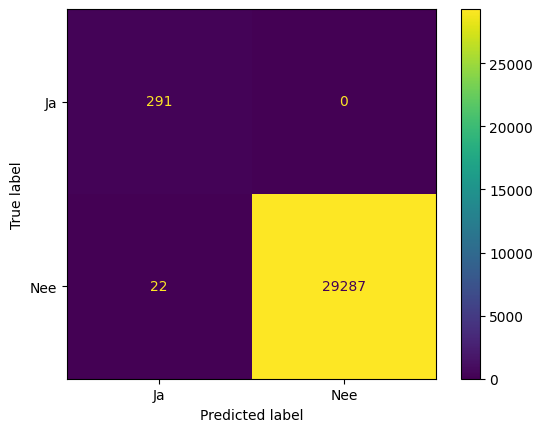

              precision    recall  f1-score   support

          Ja       0.93      1.00      0.96       291
         Nee       1.00      1.00      1.00     29309

    accuracy                           1.00     29600
   macro avg       0.96      1.00      0.98     29600
weighted avg       1.00      1.00      1.00     29600



In [18]:
# Ngram 2 Stopwords kept
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), lowercase=True, token_pattern=r"(?u)\b\w\w+\b|\+|\-")),
    ('clf', SGDClassifier(early_stopping=True, n_iter_no_change=5, validation_fraction = 0.25, verbose=3)),
])
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameter_grid, random_state=500, verbose=3, scoring='f1_macro')
random_search.fit(X_train, y_train)  
predicted_nb = random_search.predict(X_test)
print(np.mean(predicted_nb == y_test))
cm = confusion_matrix(y_test, predicted_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=random_search.classes_)
disp.plot()

plt.show()
print(metrics.classification_report(y_test, predicted_nb,
    target_names=random_search.classes_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
-- Epoch 1
Norm: 87.93, NNZs: 361, Bias: 0.000000, T: 71040, Avg. loss: 0.081515
Total training time: 1.05 seconds.
-- Epoch 2
Norm: 118.73, NNZs: 105, Bias: 0.000000, T: 142080, Avg. loss: 0.053753
Total training time: 2.14 seconds.
-- Epoch 3
Norm: 142.08, NNZs: 76, Bias: 0.000000, T: 213120, Avg. loss: 0.046827
Total training time: 3.23 seconds.
-- Epoch 4
Norm: 161.38, NNZs: 61, Bias: 0.000000, T: 284160, Avg. loss: 0.043371
Total training time: 4.30 seconds.
-- Epoch 5
Norm: 178.36, NNZs: 54, Bias: 0.000000, T: 355200, Avg. loss: 0.041255
Total training time: 5.37 seconds.
-- Epoch 6
Norm: 193.56, NNZs: 52, Bias: 0.000000, T: 426240, Avg. loss: 0.039422
Total training time: 6.45 seconds.
-- Epoch 7
Norm: 196.34, NNZs: 52, Bias: 0.000000, T: 497280, Avg. loss: 0.038820
Total training time: 7.55 seconds.
-- Epoch 8
Norm: 199.08, NNZs: 51, Bias: 0.000000, T: 568320, Avg. loss: 0.038648
Total training time: 8.63 seconds.
-- 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.211 total time= 2.4min
-- Epoch 1
Norm: 87.77, NNZs: 385, Bias: 0.000000, T: 71040, Avg. loss: 0.081782
Total training time: 0.99 seconds.
-- Epoch 2
Norm: 118.56, NNZs: 104, Bias: 0.000000, T: 142080, Avg. loss: 0.053818
Total training time: 2.00 seconds.
-- Epoch 3
Norm: 141.70, NNZs: 73, Bias: 0.000000, T: 213120, Avg. loss: 0.047138
Total training time: 3.07 seconds.
-- Epoch 4
Norm: 161.18, NNZs: 61, Bias: 0.000000, T: 284160, Avg. loss: 0.043395
Total training time: 4.11 seconds.
-- Epoch 5
Norm: 178.11, NNZs: 55, Bias: 0.000000, T: 355200, Avg. loss: 0.041037
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.210 total time= 2.2min
-- Epoch 1
Norm: 87.12, NNZs: 365, Bias: 0.000000, T: 71040, Avg. loss: 0.082948
Total training time: 1.00 seconds.
-- Epoch 2
Norm: 118.15, NNZs: 102, Bias: 0.000000, T: 142080, Avg. loss: 0.054849
Total training time: 2.10 seconds.
-- Epoch 3
Norm: 141.44, NNZs: 72, Bias: 0.000000, T: 213120, Avg. loss: 0.047613
Total training time: 3.20 seconds.
-- Epoch 4
Norm: 160.91, NNZs: 64, Bias: 0.000000, T: 284160, Avg. loss: 0.043832
Total training time: 4.30 seconds.
-- Epoch 5
Norm: 178.09, NNZs: 52, Bias: 0.000000, T: 355200, Avg. loss: 0.041437
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.210 total time= 2.3min
-- Epoch 1
Norm: 87.65, NNZs: 393, Bias: 0.000000, T: 71040, Avg. loss: 0.080698
Total training time: 1.04 seconds.
-- Epoch 2
Norm: 118.41, NNZs: 104, Bias: 0.000000, T: 142080, Avg. loss: 0.053364
Total training time: 2.16 seconds.
-- Epoch 3
Norm: 141.74, NNZs: 72, Bias: 0.000000, T: 213120, Avg. loss: 0.046645
Total training time: 3.30 seconds.
-- Epoch 4
Norm: 161.13, NNZs: 59, Bias: 0.000000, T: 284160, Avg. loss: 0.042705
Total training time: 4.41 seconds.
-- Epoch 5
Norm: 178.02, NNZs: 54, Bias: 0.000000, T: 355200, Avg. loss: 0.040581
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.210 total time= 2.3min
-- Epoch 1
Norm: 87.79, NNZs: 379, Bias: 0.000000, T: 71040, Avg. loss: 0.082076
Total training time: 1.05 seconds.
-- Epoch 2
Norm: 118.96, NNZs: 107, Bias: 0.000000, T: 142080, Avg. loss: 0.053905
Total training time: 2.14 seconds.
-- Epoch 3
Norm: 142.30, NNZs: 76, Bias: 0.000000, T: 213120, Avg. loss: 0.047039
Total training time: 3.25 seconds.
-- Epoch 4
Norm: 161.76, NNZs: 62, Bias: 0.000000, T: 284160, Avg. loss: 0.043332
Total training time: 4.32 seconds.
-- Epoch 5
Norm: 178.78, NNZs: 54, Bias: 0.000000, T: 355200, Avg. loss: 0.040864
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.207 total time= 2.3min
-- Epoch 1
Norm: 36.10, NNZs: 49, Bias: 0.000000, T: 71040, Avg. loss: 0.001525
Total training time: 0.49 seconds.
-- Epoch 2
Norm: 36.71, NNZs: 46, Bias: 0.000000, T: 142080, Avg. loss: 0.001416
Total training time: 1.00 seconds.
-- Epoch 3
Norm: 37.04, NNZs: 46, Bias: 0.000000, T: 213120, Avg. loss: 0.001398
Total training time: 1.50 seconds.
-- Epoch 4
Norm: 37.28, NNZs: 45, Bias: 0.000000, T: 284160, Avg. loss: 0.001380
Total training time: 1.99 seconds.
-- Epoch 5
Norm: 37.46, NNZs: 45, Bias: 0.000000, T: 355200, Avg. loss: 0.001381
Total training time:

-- Epoch 1
Norm: 83.34, NNZs: 303, Bias: 0.000000, T: 71040, Avg. loss: 0.020455
Total training time: 0.71 seconds.
-- Epoch 2
Norm: 108.64, NNZs: 95, Bias: 0.000000, T: 142080, Avg. loss: 0.012874
Total training time: 1.42 seconds.
-- Epoch 3
Norm: 127.75, NNZs: 86, Bias: 0.000000, T: 213120, Avg. loss: 0.011690
Total training time: 1.99 seconds.
-- Epoch 4
Norm: 143.91, NNZs: 85, Bias: 0.000000, T: 284160, Avg. loss: 0.011353
Total training time: 2.60 seconds.
-- Epoch 5
Norm: 158.11, NNZs: 72, Bias: 0.000000, T: 355200, Avg. loss: 0.011178
Total training time: 3.14 seconds.
-- Epoch 6
Norm: 170.89, NNZs: 69, Bias: 0.000000, T: 426240, Avg. loss: 0.010831
Total training time: 3.69 seconds.
Convergence after 6 epochs took 3.76 seconds
[CV 2/5] END clf__average=False, clf__class_weight=None, clf__epsilon=0.03646223783802971, clf__eta0=0.7491267567674796, clf__fit_intercept=False, clf__l1_ratio=0.775818217437024, clf__learning_rate=constant, clf__loss=squared_hinge, clf__max_iter=20, cl

Norm: 270909417622476.53, NNZs: 819577, Bias: 0.000000, T: 355200, Avg. loss: 2229194187811481223954432.000000
Total training time: 3.97 seconds.
-- Epoch 6
Norm: 232199386517852.44, NNZs: 819520, Bias: 0.000000, T: 426240, Avg. loss: 3073730996006176597999616.000000
Total training time: 4.77 seconds.
Convergence after 6 epochs took 4.83 seconds
[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.24457156361183285, clf__eta0=0.332929742792607, clf__fit_intercept=False, clf__l1_ratio=0.920539731041378, clf__learning_rate=constant, clf__loss=squared_error, clf__max_iter=100, clf__penalty=l1, clf__power_t=0.5734177157821045, clf__shuffle=True, clf__tol=0.6492274795888617, clf__warm_start=True, tfidf__max_df=0.95, tfidf__min_df=5;, score=0.343 total time= 1.8min
-- Epoch 1
Norm: 277929644534741.78, NNZs: 820997, Bias: 0.000000, T: 71040, Avg. loss: 1170095845691375774334976.000000
Total training time: 0.76 seconds.
-- Epoch 2
Norm: 208038697347671.12, NNZs: 820301, B

-- Epoch 1
Norm: 4.08, NNZs: 1453530, Bias: 0.439073, T: 71040, Avg. loss: 0.042313
Total training time: 0.44 seconds.
-- Epoch 2
Norm: 4.11, NNZs: 1453530, Bias: 0.501973, T: 142080, Avg. loss: 0.016634
Total training time: 0.87 seconds.
-- Epoch 3
Norm: 4.08, NNZs: 1453530, Bias: 0.536461, T: 213120, Avg. loss: 0.012743
Total training time: 1.33 seconds.
-- Epoch 4
Norm: 4.05, NNZs: 1453530, Bias: 0.560378, T: 284160, Avg. loss: 0.010880
Total training time: 1.82 seconds.
-- Epoch 5
Norm: 4.01, NNZs: 1453530, Bias: 0.578634, T: 355200, Avg. loss: 0.009771
Total training time: 2.28 seconds.
-- Epoch 6
Norm: 3.98, NNZs: 1453530, Bias: 0.593336, T: 426240, Avg. loss: 0.009032
Total training time: 2.76 seconds.
Convergence after 6 epochs took 2.83 seconds
[CV 5/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.2527955528897454, clf__eta0=0.4377192284389271, clf__fit_intercept=True, clf__l1_ratio=0.6515110441465675, clf__learning_rate=invscaling, clf__loss=huber, clf__max_i

-- Epoch 1
Norm: 406.39, NNZs: 355, Bias: 0.000000, T: 71040, Avg. loss: 0.146349
Total training time: 0.38 seconds.
-- Epoch 2
Norm: 497.53, NNZs: 121, Bias: 0.000000, T: 142080, Avg. loss: 0.032249
Total training time: 0.75 seconds.
-- Epoch 3
Norm: 572.19, NNZs: 105, Bias: 0.000000, T: 213120, Avg. loss: 0.027586
Total training time: 1.12 seconds.
-- Epoch 4
Norm: 629.75, NNZs: 85, Bias: 0.000000, T: 284160, Avg. loss: 0.025333
Total training time: 1.53 seconds.
-- Epoch 5
Norm: 680.74, NNZs: 80, Bias: 0.000000, T: 355200, Avg. loss: 0.021923
Total training time: 1.95 seconds.
-- Epoch 6
Norm: 726.12, NNZs: 72, Bias: 0.000000, T: 426240, Avg. loss: 0.022485
Total training time: 2.36 seconds.
Convergence after 6 epochs took 2.42 seconds
[CV 2/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.3509613152086368, clf__eta0=0.9934401124631351, clf__fit_intercept=False, clf__l1_ratio=0.5204998682261415, clf__learning_rate=constant, clf__loss=hinge, clf__max_iter=40, clf

-- Epoch 1
Norm: 1.56, NNZs: 820953, Bias: 0.000000, T: 71040, Avg. loss: 0.797298
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 1.76, NNZs: 820953, Bias: 0.000000, T: 142080, Avg. loss: 0.824577
Total training time: 0.46 seconds.
-- Epoch 3
Norm: 1.86, NNZs: 820953, Bias: 0.000000, T: 213120, Avg. loss: 0.819372
Total training time: 0.72 seconds.
-- Epoch 4
Norm: 1.94, NNZs: 820953, Bias: 0.000000, T: 284160, Avg. loss: 0.810775
Total training time: 0.98 seconds.
-- Epoch 5
Norm: 2.01, NNZs: 820953, Bias: 0.000000, T: 355200, Avg. loss: 0.804232
Total training time: 1.24 seconds.
-- Epoch 6
Norm: 2.06, NNZs: 820953, Bias: 0.000000, T: 426240, Avg. loss: 0.795612
Total training time: 1.50 seconds.
Convergence after 6 epochs took 1.56 seconds
[CV 4/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.28658617296069355, clf__eta0=0.03398405924608927, clf__fit_intercept=False, clf__l1_ratio=0.08227014493927165, clf__learning_rate=invscaling, clf__loss=epsilon_insens

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.709 total time= 1.8min
-- Epoch 1
Norm: 68.66, NNZs: 821062, Bias: 0.000000, T: 71040, Avg. loss: 0.272687
Total training time: 0.37 seconds.
-- Epoch 2
Norm: 67.75, NNZs: 821062, Bias: 0.000000, T: 142080, Avg. loss: 0.237687
Total training time: 0.72 seconds.
-- Epoch 3
Norm: 67.77, NNZs: 821062, Bias: 0.000000, T: 213120, Avg. loss: 0.237843
Total training time: 1.09 seconds.
-- Epoch 4
Norm: 67.77, NNZs: 821062, Bias: 0.000000, T: 284160, Avg. loss: 0.237842
Total training time: 1.44 seconds.
-- Epoch 5
Norm: 67.77, NNZs: 821062, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.705 total time= 1.8min
-- Epoch 1
Norm: 69.55, NNZs: 819571, Bias: 0.000000, T: 71040, Avg. loss: 0.275933
Total training time: 0.36 seconds.
-- Epoch 2
Norm: 68.48, NNZs: 819571, Bias: 0.000000, T: 142080, Avg. loss: 0.237503
Total training time: 0.82 seconds.
-- Epoch 3
Norm: 68.50, NNZs: 819571, Bias: 0.000000, T: 213120, Avg. loss: 0.237879
Total training time: 1.21 seconds.
-- Epoch 4
Norm: 68.50, NNZs: 819571, Bias: 0.000000, T: 284160, Avg. loss: 0.237868
Total training time: 1.62 seconds.
-- Epoch 5
Norm: 68.50, NNZs: 819571, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.720 total time= 1.8min
-- Epoch 1
Norm: 69.56, NNZs: 820976, Bias: 0.000000, T: 71040, Avg. loss: 0.271677
Total training time: 0.36 seconds.
-- Epoch 2
Norm: 68.57, NNZs: 820976, Bias: 0.000000, T: 142080, Avg. loss: 0.236088
Total training time: 0.76 seconds.
-- Epoch 3
Norm: 68.59, NNZs: 820976, Bias: 0.000000, T: 213120, Avg. loss: 0.236373
Total training time: 1.16 seconds.
-- Epoch 4
Norm: 68.59, NNZs: 820976, Bias: 0.000000, T: 284160, Avg. loss: 0.236365
Total training time: 1.56 seconds.
-- Epoch 5
Norm: 68.59, NNZs: 820976, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.729 total time= 1.8min
-- Epoch 1
Norm: 74.61, NNZs: 816977, Bias: 0.000000, T: 71040, Avg. loss: 0.275827
Total training time: 0.38 seconds.
-- Epoch 2
Norm: 73.75, NNZs: 816977, Bias: 0.000000, T: 142080, Avg. loss: 0.241947
Total training time: 0.75 seconds.
-- Epoch 3
Norm: 73.77, NNZs: 816977, Bias: 0.000000, T: 213120, Avg. loss: 0.242162
Total training time: 1.13 seconds.
-- Epoch 4
Norm: 73.77, NNZs: 816977, Bias: 0.000000, T: 284160, Avg. loss: 0.242157
Total training time: 1.50 seconds.
-- Epoch 5
Norm: 73.77, NNZs: 816977, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.727 total time= 1.8min
-- Epoch 1
Norm: 49.14, NNZs: 448212, Bias: 1.527304, T: 71040, Avg. loss: 0.264427
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 28.16, NNZs: 483564, Bias: 1.410684, T: 142080, Avg. loss: 0.005034
Total training time: 0.44 seconds.
-- Epoch 3
Norm: 21.32, NNZs: 492753, Bias: 1.237508, T: 213120, Avg. loss: 0.001974
Total training time: 0.64 seconds.
-- Epoch 4
Norm: 17.05, NNZs: 496780, Bias: 1.184182, T: 284160, Avg. loss: 0.001206
Total training time: 0.91 seconds.
-- Epoch 5
Norm: 14.46, NNZs: 498898, Bias: 1.131194, T: 355200, Avg. loss: 0

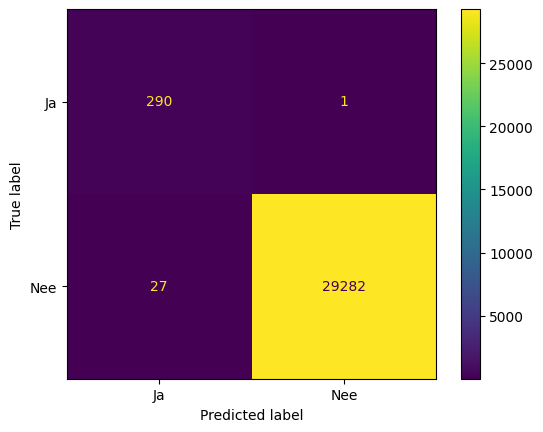

              precision    recall  f1-score   support

          Ja       0.91      1.00      0.95       291
         Nee       1.00      1.00      1.00     29309

    accuracy                           1.00     29600
   macro avg       0.96      1.00      0.98     29600
weighted avg       1.00      1.00      1.00     29600



In [8]:
# Ngram 3 Stopwords kept
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,3), lowercase=True, token_pattern=r"(?u)\b\w\w+\b|\+|\-")),
    ('clf', SGDClassifier(early_stopping=True, n_iter_no_change=5, validation_fraction = 0.25, verbose=3)),
])
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameter_grid, random_state=500, verbose=3, scoring='f1_macro')
random_search.fit(X_train, y_train)  
predicted_nb = random_search.predict(X_test)
print(np.mean(predicted_nb == y_test))
cm = confusion_matrix(y_test, predicted_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=random_search.classes_)
disp.plot()

plt.show()
print(metrics.classification_report(y_test, predicted_nb,
    target_names=random_search.classes_))

# Only negation stopwords kept

In [9]:
no_stopwords = lambda x: ' '.join([item for item in x.split() if item not in full_stopwords])
less_stopwords = lambda x: ' '.join([item for item in x.split() if item not in filtered_stopwords])

Corpus["text"] = Corpus["text"].apply(less_stopwords)
X_train, X_test, y_train, y_test = train_test_split(Corpus['text'], Corpus['label'], test_size=0.2, random_state=50)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
-- Epoch 1
Norm: 86.64, NNZs: 265, Bias: 0.000000, T: 71040, Avg. loss: 0.076358
Total training time: 0.44 seconds.
-- Epoch 2
Norm: 115.81, NNZs: 109, Bias: 0.000000, T: 142080, Avg. loss: 0.051820
Total training time: 0.89 seconds.
-- Epoch 3
Norm: 138.17, NNZs: 86, Bias: 0.000000, T: 213120, Avg. loss: 0.045733
Total training time: 1.34 seconds.
-- Epoch 4
Norm: 156.75, NNZs: 69, Bias: 0.000000, T: 284160, Avg. loss: 0.043109
Total training time: 1.77 seconds.
-- Epoch 5
Norm: 172.96, NNZs: 61, Bias: 0.000000, T: 355200, Avg. loss: 0.040795
Total training time: 2.21 seconds.
-- Epoch 6
Norm: 187.40, NNZs: 58, Bias: 0.000000, T: 426240, Avg. loss: 0.039478
Total training time: 2.65 seconds.
-- Epoch 7
Norm: 190.11, NNZs: 55, Bias: 0.000000, T: 497280, Avg. loss: 0.038851
Total training time: 3.10 seconds.
-- Epoch 8
Norm: 192.76, NNZs: 54, Bias: 0.000000, T: 568320, Avg. loss: 0.038567
Total training time: 3.55 seconds.
-- 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.217 total time=  59.1s
-- Epoch 1
Norm: 86.68, NNZs: 284, Bias: 0.000000, T: 71040, Avg. loss: 0.076620
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 116.37, NNZs: 111, Bias: 0.000000, T: 142080, Avg. loss: 0.051610
Total training time: 0.93 seconds.
-- Epoch 3
Norm: 138.95, NNZs: 83, Bias: 0.000000, T: 213120, Avg. loss: 0.045762
Total training time: 1.40 seconds.
-- Epoch 4
Norm: 157.70, NNZs: 69, Bias: 0.000000, T: 284160, Avg. loss: 0.042451
Total training time: 1.86 seconds.
-- Epoch 5
Norm: 174.11, NNZs: 62, Bias: 0.000000, T: 355200, Avg. loss: 0.040412
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.214 total time=  58.9s
-- Epoch 1
Norm: 86.75, NNZs: 262, Bias: 0.000000, T: 71040, Avg. loss: 0.076347
Total training time: 0.42 seconds.
-- Epoch 2
Norm: 116.66, NNZs: 109, Bias: 0.000000, T: 142080, Avg. loss: 0.051401
Total training time: 0.89 seconds.
-- Epoch 3
Norm: 139.07, NNZs: 87, Bias: 0.000000, T: 213120, Avg. loss: 0.045322
Total training time: 1.37 seconds.
-- Epoch 4
Norm: 157.81, NNZs: 71, Bias: 0.000000, T: 284160, Avg. loss: 0.042211
Total training time: 1.84 seconds.
-- Epoch 5
Norm: 174.19, NNZs: 64, Bias: 0.000000, T: 355200, Avg. loss: 0.040235
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.211 total time=  58.4s
-- Epoch 1
Norm: 86.29, NNZs: 271, Bias: 0.000000, T: 71040, Avg. loss: 0.076123
Total training time: 0.39 seconds.
-- Epoch 2
Norm: 116.00, NNZs: 109, Bias: 0.000000, T: 142080, Avg. loss: 0.051077
Total training time: 0.83 seconds.
-- Epoch 3
Norm: 138.29, NNZs: 84, Bias: 0.000000, T: 213120, Avg. loss: 0.045246
Total training time: 1.28 seconds.
-- Epoch 4
Norm: 157.05, NNZs: 70, Bias: 0.000000, T: 284160, Avg. loss: 0.042437
Total training time: 1.70 seconds.
-- Epoch 5
Norm: 173.40, NNZs: 63, Bias: 0.000000, T: 355200, Avg. loss: 0.040116
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.212 total time=  59.3s
-- Epoch 1
Norm: 86.26, NNZs: 281, Bias: 0.000000, T: 71040, Avg. loss: 0.077045
Total training time: 0.49 seconds.
-- Epoch 2
Norm: 115.99, NNZs: 113, Bias: 0.000000, T: 142080, Avg. loss: 0.051198
Total training time: 0.99 seconds.
-- Epoch 3
Norm: 138.56, NNZs: 86, Bias: 0.000000, T: 213120, Avg. loss: 0.045402
Total training time: 1.49 seconds.
-- Epoch 4
Norm: 157.36, NNZs: 70, Bias: 0.000000, T: 284160, Avg. loss: 0.042208
Total training time: 1.98 seconds.
-- Epoch 5
Norm: 173.64, NNZs: 62, Bias: 0.000000, T: 355200, Avg. loss: 0.040405
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.210 total time= 1.0min
-- Epoch 1
Norm: 79836036074109.19, NNZs: 395434, Bias: 0.000000, T: 71040, Avg. loss: 61720040850122893950976.000000
Total training time: 0.35 seconds.
-- Epoch 2
Norm: 74432730973072.62, NNZs: 395436, Bias: 0.000000, T: 142080, Avg. loss: 50476040900109353877504.000000
Total training time: 0.69 seconds.
-- Epoch 3
Norm: 71656164686750.97, NNZs: 395436, Bias: 0.000000, T: 213120, Avg. loss: 40447248144885832744960.000000
Total training time: 1.03 seconds.
-- Epoch 4
Norm: 69826018888253.57, NNZs: 395436, Bias: 0.000000, T: 284160, Avg. loss: 358291945864962

[CV 1/5] END clf__average=False, clf__class_weight=None, clf__epsilon=0.03646223783802971, clf__eta0=0.7491267567674796, clf__fit_intercept=False, clf__l1_ratio=0.775818217437024, clf__learning_rate=constant, clf__loss=squared_hinge, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.4028006727705291, clf__shuffle=True, clf__tol=0.1730703028465106, clf__warm_start=True, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.973 total time=  50.4s
-- Epoch 1
Norm: 81.56, NNZs: 217, Bias: 0.000000, T: 71040, Avg. loss: 0.020241
Total training time: 0.37 seconds.
-- Epoch 2
Norm: 107.09, NNZs: 111, Bias: 0.000000, T: 142080, Avg. loss: 0.012648
Total training time: 0.67 seconds.
-- Epoch 3
Norm: 126.06, NNZs: 99, Bias: 0.000000, T: 213120, Avg. loss: 0.011409
Total training time: 0.99 seconds.
-- Epoch 4
Norm: 141.81, NNZs: 96, Bias: 0.000000, T: 284160, Avg. loss: 0.010661
Total training time: 1.28 seconds.
-- Epoch 5
Norm: 155.48, NNZs: 89, Bias: 0.000000, T: 355200, Avg. loss: 0.010285
Total trai

Norm: 203668534740163.72, NNZs: 394321, Bias: 0.000000, T: 142080, Avg. loss: 3754656363543301887885312.000000
Total training time: 0.84 seconds.
-- Epoch 3
Norm: 270961863645178.91, NNZs: 394745, Bias: 0.000000, T: 213120, Avg. loss: 2540873380939995902115840.000000
Total training time: 1.26 seconds.
-- Epoch 4
Norm: 232152629718171.34, NNZs: 394658, Bias: 0.000000, T: 284160, Avg. loss: 3390488081156215406592000.000000
Total training time: 1.67 seconds.
-- Epoch 5
Norm: 264515581424021.00, NNZs: 394744, Bias: 0.000000, T: 355200, Avg. loss: 2405236325652317664706560.000000
Total training time: 2.08 seconds.
-- Epoch 6
Norm: 238565228889103.28, NNZs: 394714, Bias: 0.000000, T: 426240, Avg. loss: 3244447243043161677758464.000000
Total training time: 2.50 seconds.
Convergence after 6 epochs took 2.54 seconds
[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.24457156361183285, clf__eta0=0.332929742792607, clf__fit_intercept=False, clf__l1_ratio=0.920539731041378,

-- Epoch 6
Norm: 4.07, NNZs: 675003, Bias: 0.566846, T: 426240, Avg. loss: 0.009029
Total training time: 1.28 seconds.
Convergence after 6 epochs took 1.32 seconds
[CV 4/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.2527955528897454, clf__eta0=0.4377192284389271, clf__fit_intercept=True, clf__l1_ratio=0.6515110441465675, clf__learning_rate=invscaling, clf__loss=huber, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.47239053945705856, clf__shuffle=False, clf__tol=0.9089234089706554, clf__warm_start=False, tfidf__max_df=0.95, tfidf__min_df=3;, score=0.498 total time=  49.5s
-- Epoch 1
Norm: 4.08, NNZs: 671845, Bias: 0.418664, T: 71040, Avg. loss: 0.040182
Total training time: 0.22 seconds.
-- Epoch 2
Norm: 4.15, NNZs: 671845, Bias: 0.478812, T: 142080, Avg. loss: 0.015951
Total training time: 0.48 seconds.
-- Epoch 3
Norm: 4.15, NNZs: 671845, Bias: 0.512126, T: 213120, Avg. loss: 0.012319
Total training time: 0.74 seconds.
-- Epoch 4
Norm: 4.12, NNZs: 671845, Bias: 0

Norm: 657.85, NNZs: 106, Bias: 0.000000, T: 355200, Avg. loss: 0.023242
Total training time: 1.03 seconds.
-- Epoch 6
Norm: 700.40, NNZs: 93, Bias: 0.000000, T: 426240, Avg. loss: 0.024994
Total training time: 1.24 seconds.
Convergence after 6 epochs took 1.27 seconds
[CV 1/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.3509613152086368, clf__eta0=0.9934401124631351, clf__fit_intercept=False, clf__l1_ratio=0.5204998682261415, clf__learning_rate=constant, clf__loss=hinge, clf__max_iter=40, clf__penalty=l1, clf__power_t=0.5098574122392232, clf__shuffle=False, clf__tol=0.5563103350645606, clf__warm_start=False, tfidf__max_df=0.95, tfidf__min_df=5;, score=0.933 total time=  48.8s
-- Epoch 1
Norm: 373.99, NNZs: 390, Bias: 0.000000, T: 71040, Avg. loss: 0.206064
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 450.05, NNZs: 138, Bias: 0.000000, T: 142080, Avg. loss: 0.028906
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 515.52, NNZs: 107, Bias: 0.000000, T: 21

Norm: 1.91, NNZs: 394743, Bias: 0.000000, T: 284160, Avg. loss: 0.806853
Total training time: 0.60 seconds.
-- Epoch 5
Norm: 1.97, NNZs: 394743, Bias: 0.000000, T: 355200, Avg. loss: 0.795793
Total training time: 0.76 seconds.
-- Epoch 6
Norm: 2.03, NNZs: 394743, Bias: 0.000000, T: 426240, Avg. loss: 0.786512
Total training time: 0.92 seconds.
Convergence after 6 epochs took 0.96 seconds
[CV 3/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.28658617296069355, clf__eta0=0.03398405924608927, clf__fit_intercept=False, clf__l1_ratio=0.08227014493927165, clf__learning_rate=invscaling, clf__loss=epsilon_insensitive, clf__max_iter=60, clf__penalty=l2, clf__power_t=0.5467473202425025, clf__shuffle=True, clf__tol=0.9099604695658384, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.450 total time=  48.2s
-- Epoch 1
Norm: 1.63, NNZs: 395339, Bias: 0.000000, T: 71040, Avg. loss: 0.823935
Total training time: 0.12 seconds.
-- Epoch 2
Norm: 1.77, NNZs: 395339

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.679 total time=  50.4s
-- Epoch 1
Norm: 69.29, NNZs: 395504, Bias: 0.000000, T: 71040, Avg. loss: 0.283130
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 68.22, NNZs: 395504, Bias: 0.000000, T: 142080, Avg. loss: 0.244460
Total training time: 0.34 seconds.
-- Epoch 3
Norm: 68.25, NNZs: 395504, Bias: 0.000000, T: 213120, Avg. loss: 0.244760
Total training time: 0.53 seconds.
-- Epoch 4
Norm: 68.25, NNZs: 395504, Bias: 0.000000, T: 284160, Avg. loss: 0.244751
Total training time: 0.71 seconds.
-- Epoch 5
Norm: 68.25, NNZs: 395504, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.684 total time=  50.4s
-- Epoch 1
Norm: 69.10, NNZs: 394756, Bias: 0.000000, T: 71040, Avg. loss: 0.277659
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 68.03, NNZs: 394756, Bias: 0.000000, T: 142080, Avg. loss: 0.240206
Total training time: 0.37 seconds.
-- Epoch 3
Norm: 68.06, NNZs: 394756, Bias: 0.000000, T: 213120, Avg. loss: 0.240451
Total training time: 0.57 seconds.
-- Epoch 4
Norm: 68.06, NNZs: 394756, Bias: 0.000000, T: 284160, Avg. loss: 0.240447
Total training time: 0.77 seconds.
-- Epoch 5
Norm: 68.06, NNZs: 394756, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.684 total time=  50.2s
-- Epoch 1
Norm: 68.87, NNZs: 395339, Bias: 0.000000, T: 71040, Avg. loss: 0.278261
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 67.91, NNZs: 395339, Bias: 0.000000, T: 142080, Avg. loss: 0.242255
Total training time: 0.39 seconds.
-- Epoch 3
Norm: 67.93, NNZs: 395339, Bias: 0.000000, T: 213120, Avg. loss: 0.242294
Total training time: 0.58 seconds.
-- Epoch 4
Norm: 67.93, NNZs: 395339, Bias: 0.000000, T: 284160, Avg. loss: 0.242297
Total training time: 0.78 seconds.
-- Epoch 5
Norm: 67.93, NNZs: 395339, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.691 total time=  51.3s
-- Epoch 1
Norm: 72.96, NNZs: 393403, Bias: 0.000000, T: 71040, Avg. loss: 0.290988
Total training time: 0.17 seconds.
-- Epoch 2
Norm: 72.00, NNZs: 393403, Bias: 0.000000, T: 142080, Avg. loss: 0.255921
Total training time: 0.38 seconds.
-- Epoch 3
Norm: 72.02, NNZs: 393403, Bias: 0.000000, T: 213120, Avg. loss: 0.255833
Total training time: 0.57 seconds.
-- Epoch 4
Norm: 72.02, NNZs: 393403, Bias: 0.000000, T: 284160, Avg. loss: 0.255842
Total training time: 0.77 seconds.
-- Epoch 5
Norm: 72.02, NNZs: 393403, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.697 total time=  51.8s
-- Epoch 1
Norm: 50.09, NNZs: 228745, Bias: 2.038632, T: 71040, Avg. loss: 0.245609
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 30.71, NNZs: 242307, Bias: 1.783376, T: 142080, Avg. loss: 0.008862
Total training time: 0.26 seconds.
-- Epoch 3
Norm: 22.75, NNZs: 246170, Bias: 1.649319, T: 213120, Avg. loss: 0.002793
Total training time: 0.38 seconds.
-- Epoch 4
Norm: 18.52, NNZs: 247586, Bias: 1.553333, T: 284160, Avg. loss: 0.000979
Total training time: 0.49 seconds.
-- Epoch 5
Norm: 16.03, NNZs: 248620, Bias: 1.478441, T: 355200, Avg. loss: 0

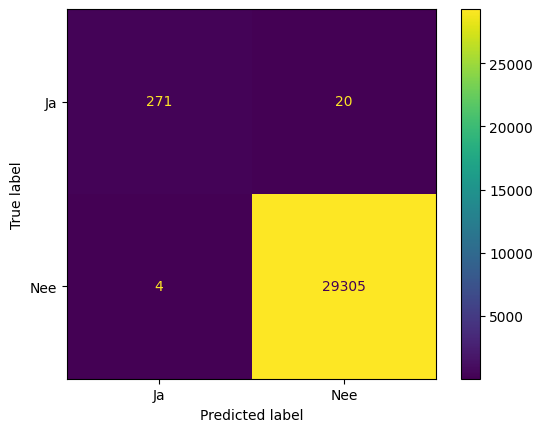

              precision    recall  f1-score   support

          Ja       0.99      0.93      0.96       291
         Nee       1.00      1.00      1.00     29309

    accuracy                           1.00     29600
   macro avg       0.99      0.97      0.98     29600
weighted avg       1.00      1.00      1.00     29600



In [10]:
# Ngram 2 Less stopwords
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), lowercase=True, token_pattern=r"(?u)\b\w\w+\b|\+|\-")),
    ('clf', SGDClassifier(early_stopping=True, n_iter_no_change=5, validation_fraction = 0.25, verbose=3)),
])
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameter_grid, random_state=500, verbose=3, scoring='f1_macro')
random_search.fit(X_train, y_train)  
predicted_nb = random_search.predict(X_test)
print(np.mean(predicted_nb == y_test))
cm = confusion_matrix(y_test, predicted_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=random_search.classes_)
disp.plot()

plt.show()
print(metrics.classification_report(y_test, predicted_nb,
    target_names=random_search.classes_))

# No stopwords

In [11]:
Corpus["text"] = Corpus["text"].apply(no_stopwords)
X_train, X_test, y_train, y_test = train_test_split(Corpus['text'], Corpus['label'], test_size=0.2, random_state=50)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
-- Epoch 1
Norm: 88.59, NNZs: 309, Bias: 0.000000, T: 71040, Avg. loss: 0.082622
Total training time: 0.36 seconds.
-- Epoch 2
Norm: 119.05, NNZs: 117, Bias: 0.000000, T: 142080, Avg. loss: 0.057881
Total training time: 0.77 seconds.
-- Epoch 3
Norm: 141.91, NNZs: 90, Bias: 0.000000, T: 213120, Avg. loss: 0.053001
Total training time: 1.17 seconds.
-- Epoch 4
Norm: 160.90, NNZs: 80, Bias: 0.000000, T: 284160, Avg. loss: 0.050142
Total training time: 1.57 seconds.
-- Epoch 5
Norm: 177.38, NNZs: 75, Bias: 0.000000, T: 355200, Avg. loss: 0.048463
Total training time: 1.99 seconds.
-- Epoch 6
Norm: 192.30, NNZs: 67, Bias: 0.000000, T: 426240, Avg. loss: 0.047736
Total training time: 2.41 seconds.
-- Epoch 7
Norm: 194.98, NNZs: 67, Bias: 0.000000, T: 497280, Avg. loss: 0.047121
Total training time: 2.83 seconds.
-- Epoch 8
Norm: 197.62, NNZs: 67, Bias: 0.000000, T: 568320, Avg. loss: 0.047078
Total training time: 3.21 seconds.
-- 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.183 total time=  56.0s
-- Epoch 1
Norm: 88.19, NNZs: 312, Bias: 0.000000, T: 71040, Avg. loss: 0.082957
Total training time: 0.34 seconds.
-- Epoch 2
Norm: 118.22, NNZs: 115, Bias: 0.000000, T: 142080, Avg. loss: 0.059081
Total training time: 0.70 seconds.
-- Epoch 3
Norm: 141.28, NNZs: 94, Bias: 0.000000, T: 213120, Avg. loss: 0.053909
Total training time: 1.06 seconds.
-- Epoch 4
Norm: 160.18, NNZs: 80, Bias: 0.000000, T: 284160, Avg. loss: 0.051067
Total training time: 1.42 seconds.
-- Epoch 5
Norm: 176.77, NNZs: 75, Bias: 0.000000, T: 355200, Avg. loss: 0.049572
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.185 total time=  55.6s
-- Epoch 1
Norm: 87.99, NNZs: 288, Bias: 0.000000, T: 71040, Avg. loss: 0.083294
Total training time: 0.33 seconds.
-- Epoch 2
Norm: 118.27, NNZs: 119, Bias: 0.000000, T: 142080, Avg. loss: 0.059643
Total training time: 0.73 seconds.
-- Epoch 3
Norm: 141.07, NNZs: 93, Bias: 0.000000, T: 213120, Avg. loss: 0.053849
Total training time: 1.09 seconds.
-- Epoch 4
Norm: 159.97, NNZs: 85, Bias: 0.000000, T: 284160, Avg. loss: 0.051505
Total training time: 1.47 seconds.
-- Epoch 5
Norm: 176.51, NNZs: 77, Bias: 0.000000, T: 355200, Avg. loss: 0.049819
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.186 total time=  54.6s
-- Epoch 1
Norm: 88.05, NNZs: 264, Bias: 0.000000, T: 71040, Avg. loss: 0.083431
Total training time: 0.35 seconds.
-- Epoch 2
Norm: 118.34, NNZs: 121, Bias: 0.000000, T: 142080, Avg. loss: 0.059230
Total training time: 0.74 seconds.
-- Epoch 3
Norm: 141.27, NNZs: 92, Bias: 0.000000, T: 213120, Avg. loss: 0.053730
Total training time: 1.12 seconds.
-- Epoch 4
Norm: 160.23, NNZs: 82, Bias: 0.000000, T: 284160, Avg. loss: 0.050990
Total training time: 1.51 seconds.
-- Epoch 5
Norm: 176.86, NNZs: 74, Bias: 0.000000, T: 355200, Avg. loss: 0.049719
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.179 total time=  55.1s
-- Epoch 1
Norm: 88.02, NNZs: 295, Bias: 0.000000, T: 71040, Avg. loss: 0.083401
Total training time: 0.37 seconds.
-- Epoch 2
Norm: 118.48, NNZs: 118, Bias: 0.000000, T: 142080, Avg. loss: 0.059064
Total training time: 0.77 seconds.
-- Epoch 3
Norm: 141.34, NNZs: 96, Bias: 0.000000, T: 213120, Avg. loss: 0.053520
Total training time: 1.19 seconds.
-- Epoch 4
Norm: 160.40, NNZs: 80, Bias: 0.000000, T: 284160, Avg. loss: 0.050691
Total training time: 1.58 seconds.
-- Epoch 5
Norm: 176.91, NNZs: 73, Bias: 0.000000, T: 355200, Avg. loss: 0.049327
Total training

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.183 total time=  55.0s
-- Epoch 1
Norm: 119206172009120.28, NNZs: 393895, Bias: 0.000000, T: 71040, Avg. loss: 137835144452841161097216.000000
Total training time: 0.33 seconds.
-- Epoch 2
Norm: 112588723728507.36, NNZs: 393895, Bias: 0.000000, T: 142080, Avg. loss: 119320075638963651477504.000000
Total training time: 0.66 seconds.
-- Epoch 3
Norm: 109221548206647.45, NNZs: 393895, Bias: 0.000000, T: 213120, Avg. loss: 98974199811005017489408.000000
Total training time: 1.00 seconds.
-- Epoch 4
Norm: 106996807467761.23, NNZs: 393895, Bias: 0.000000, T: 284160, Avg. loss: 895352507

[CV 1/5] END clf__average=False, clf__class_weight=None, clf__epsilon=0.03646223783802971, clf__eta0=0.7491267567674796, clf__fit_intercept=False, clf__l1_ratio=0.775818217437024, clf__learning_rate=constant, clf__loss=squared_hinge, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.4028006727705291, clf__shuffle=True, clf__tol=0.1730703028465106, clf__warm_start=True, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.838 total time=  49.3s
-- Epoch 1
Norm: 88.23, NNZs: 282, Bias: 0.000000, T: 71040, Avg. loss: 0.028388
Total training time: 0.23 seconds.
-- Epoch 2
Norm: 117.68, NNZs: 140, Bias: 0.000000, T: 142080, Avg. loss: 0.022461
Total training time: 0.49 seconds.
-- Epoch 3
Norm: 140.95, NNZs: 130, Bias: 0.000000, T: 213120, Avg. loss: 0.022462
Total training time: 0.74 seconds.
-- Epoch 4
Norm: 160.48, NNZs: 126, Bias: 0.000000, T: 284160, Avg. loss: 0.021790
Total training time: 0.99 seconds.
-- Epoch 5
Norm: 177.94, NNZs: 121, Bias: 0.000000, T: 355200, Avg. loss: 0.021699
Total t

Norm: 213361934215848.81, NNZs: 392768, Bias: 0.000000, T: 142080, Avg. loss: 3514787172486623854067712.000000
Total training time: 0.79 seconds.
-- Epoch 3
Norm: 265228646307035.69, NNZs: 393079, Bias: 0.000000, T: 213120, Avg. loss: 2764110759145304162828288.000000
Total training time: 1.21 seconds.
-- Epoch 4
Norm: 225971455452349.97, NNZs: 393016, Bias: 0.000000, T: 284160, Avg. loss: 3299641876266887111770112.000000
Total training time: 1.62 seconds.
-- Epoch 5
Norm: 257437214386945.78, NNZs: 393082, Bias: 0.000000, T: 355200, Avg. loss: 2602615620734457254772736.000000
Total training time: 2.03 seconds.
-- Epoch 6
Norm: 225332166197445.44, NNZs: 393053, Bias: 0.000000, T: 426240, Avg. loss: 3273614405008877370212352.000000
Total training time: 2.45 seconds.
Convergence after 6 epochs took 2.48 seconds
[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.24457156361183285, clf__eta0=0.332929742792607, clf__fit_intercept=False, clf__l1_ratio=0.920539731041378,

-- Epoch 6
Norm: 4.10, NNZs: 678259, Bias: 0.575331, T: 426240, Avg. loss: 0.008814
Total training time: 1.28 seconds.
Convergence after 6 epochs took 1.31 seconds
[CV 4/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.2527955528897454, clf__eta0=0.4377192284389271, clf__fit_intercept=True, clf__l1_ratio=0.6515110441465675, clf__learning_rate=invscaling, clf__loss=huber, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.47239053945705856, clf__shuffle=False, clf__tol=0.9089234089706554, clf__warm_start=False, tfidf__max_df=0.95, tfidf__min_df=3;, score=0.498 total time=  50.5s
-- Epoch 1
Norm: 4.12, NNZs: 674837, Bias: 0.432103, T: 71040, Avg. loss: 0.041177
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 4.20, NNZs: 674837, Bias: 0.491880, T: 142080, Avg. loss: 0.015416
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 4.19, NNZs: 674837, Bias: 0.524000, T: 213120, Avg. loss: 0.011891
Total training time: 0.63 seconds.
-- Epoch 4
Norm: 4.16, NNZs: 674837, Bias: 0

-- Epoch 5
Norm: 1008.52, NNZs: 236, Bias: 0.000000, T: 355200, Avg. loss: 0.101515
Total training time: 0.97 seconds.
-- Epoch 6
Norm: 1098.19, NNZs: 220, Bias: 0.000000, T: 426240, Avg. loss: 0.108135
Total training time: 1.16 seconds.
Convergence after 6 epochs took 1.19 seconds
[CV 1/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.3509613152086368, clf__eta0=0.9934401124631351, clf__fit_intercept=False, clf__l1_ratio=0.5204998682261415, clf__learning_rate=constant, clf__loss=hinge, clf__max_iter=40, clf__penalty=l1, clf__power_t=0.5098574122392232, clf__shuffle=False, clf__tol=0.5563103350645606, clf__warm_start=False, tfidf__max_df=0.95, tfidf__min_df=5;, score=0.777 total time=  47.3s
-- Epoch 1
Norm: 482.65, NNZs: 763, Bias: 0.000000, T: 71040, Avg. loss: 0.368839
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 655.93, NNZs: 348, Bias: 0.000000, T: 142080, Avg. loss: 0.156075
Total training time: 0.41 seconds.
-- Epoch 3
Norm: 787.74, NNZs: 299, Bias: 0

Norm: 1.97, NNZs: 393089, Bias: 0.000000, T: 284160, Avg. loss: 0.814365
Total training time: 0.60 seconds.
-- Epoch 5
Norm: 2.03, NNZs: 393089, Bias: 0.000000, T: 355200, Avg. loss: 0.804148
Total training time: 0.77 seconds.
-- Epoch 6
Norm: 2.08, NNZs: 393089, Bias: 0.000000, T: 426240, Avg. loss: 0.795873
Total training time: 0.92 seconds.
Convergence after 6 epochs took 0.96 seconds
[CV 3/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.28658617296069355, clf__eta0=0.03398405924608927, clf__fit_intercept=False, clf__l1_ratio=0.08227014493927165, clf__learning_rate=invscaling, clf__loss=epsilon_insensitive, clf__max_iter=60, clf__penalty=l2, clf__power_t=0.5467473202425025, clf__shuffle=True, clf__tol=0.9099604695658384, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.432 total time=  47.1s
-- Epoch 1
Norm: 1.49, NNZs: 393680, Bias: 0.000000, T: 71040, Avg. loss: 0.796200
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 1.69, NNZs: 393680

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.604 total time=  50.2s
-- Epoch 1
Norm: 76.78, NNZs: 393673, Bias: 0.000000, T: 71040, Avg. loss: 0.362234
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 75.77, NNZs: 393673, Bias: 0.000000, T: 142080, Avg. loss: 0.326387
Total training time: 0.33 seconds.
-- Epoch 3
Norm: 75.79, NNZs: 393673, Bias: 0.000000, T: 213120, Avg. loss: 0.326456
Total training time: 0.52 seconds.
-- Epoch 4
Norm: 75.79, NNZs: 393673, Bias: 0.000000, T: 284160, Avg. loss: 0.326453
Total training time: 0.70 seconds.
-- Epoch 5
Norm: 75.79, NNZs: 393673, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.595 total time=  51.0s
-- Epoch 1
Norm: 76.24, NNZs: 393106, Bias: 0.000000, T: 71040, Avg. loss: 0.371272
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 74.98, NNZs: 393106, Bias: 0.000000, T: 142080, Avg. loss: 0.330733
Total training time: 0.33 seconds.
-- Epoch 3
Norm: 75.01, NNZs: 393106, Bias: 0.000000, T: 213120, Avg. loss: 0.331016
Total training time: 0.51 seconds.
-- Epoch 4
Norm: 75.01, NNZs: 393106, Bias: 0.000000, T: 284160, Avg. loss: 0.331007
Total training time: 0.69 seconds.
-- Epoch 5
Norm: 75.01, NNZs: 393106, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.600 total time=  49.9s
-- Epoch 1
Norm: 74.96, NNZs: 393671, Bias: 0.000000, T: 71040, Avg. loss: 0.380493
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 73.96, NNZs: 393671, Bias: 0.000000, T: 142080, Avg. loss: 0.337192
Total training time: 0.34 seconds.
-- Epoch 3
Norm: 73.99, NNZs: 393671, Bias: 0.000000, T: 213120, Avg. loss: 0.337524
Total training time: 0.53 seconds.
-- Epoch 4
Norm: 73.99, NNZs: 393671, Bias: 0.000000, T: 284160, Avg. loss: 0.337504
Total training time: 0.73 seconds.
-- Epoch 5
Norm: 73.99, NNZs: 393671, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.596 total time=  50.8s
-- Epoch 1
Norm: 76.40, NNZs: 391616, Bias: 0.000000, T: 71040, Avg. loss: 0.375807
Total training time: 0.15 seconds.
-- Epoch 2
Norm: 75.56, NNZs: 391616, Bias: 0.000000, T: 142080, Avg. loss: 0.342465
Total training time: 0.33 seconds.
-- Epoch 3
Norm: 75.58, NNZs: 391616, Bias: 0.000000, T: 213120, Avg. loss: 0.342202
Total training time: 0.51 seconds.
-- Epoch 4
Norm: 75.57, NNZs: 391616, Bias: 0.000000, T: 284160, Avg. loss: 0.342223
Total training time: 0.69 seconds.
-- Epoch 5
Norm: 75.57, NNZs: 391616, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.601 total time=  49.7s
-- Epoch 1
Norm: 57.13, NNZs: 238082, Bias: 2.157876, T: 71040, Avg. loss: 0.431575
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 34.90, NNZs: 254564, Bias: 1.870889, T: 142080, Avg. loss: 0.017077
Total training time: 0.19 seconds.
-- Epoch 3
Norm: 26.49, NNZs: 261307, Bias: 1.698457, T: 213120, Avg. loss: 0.007161
Total training time: 0.30 seconds.
-- Epoch 4
Norm: 21.44, NNZs: 263744, Bias: 1.624121, T: 284160, Avg. loss: 0.003868
Total training time: 0.40 seconds.
-- Epoch 5
Norm: 18.45, NNZs: 264462, Bias: 1.540834, T: 355200, Avg. loss: 0

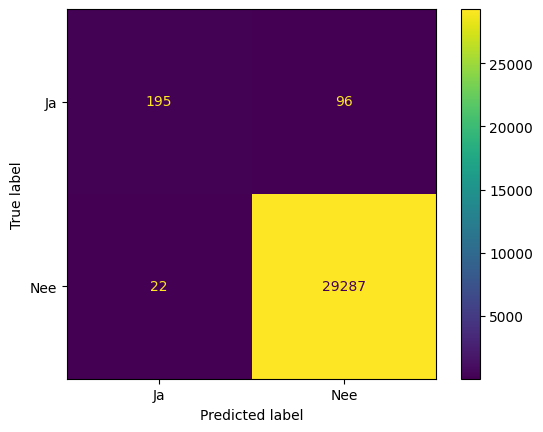

              precision    recall  f1-score   support

          Ja       0.90      0.67      0.77       291
         Nee       1.00      1.00      1.00     29309

    accuracy                           1.00     29600
   macro avg       0.95      0.83      0.88     29600
weighted avg       1.00      1.00      1.00     29600



In [12]:
# Ngram 2 No stopwords
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), lowercase=True, token_pattern=r"(?u)\b\w\w+\b|\+|\-")),
    ('clf', SGDClassifier(early_stopping=True, n_iter_no_change=5, validation_fraction = 0.25, verbose=3)),
])
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameter_grid, random_state=500, verbose=3, scoring='f1_macro')
random_search.fit(X_train, y_train)  
predicted_nb = random_search.predict(X_test)
print(np.mean(predicted_nb == y_test))
cm = confusion_matrix(y_test, predicted_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=random_search.classes_)
disp.plot()

plt.show()
print(metrics.classification_report(y_test, predicted_nb,
    target_names=random_search.classes_))

# BEST MODEL

In [13]:
# RESET CORPUS
Corpus = Corpus_backup.copy()
X_train, X_test, y_train, y_test = train_test_split(Corpus['text'], Corpus['label'], test_size=0.2, random_state=50)

In [14]:
parameter_grid = {'clf__loss':              ['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                  'clf__penalty':           ['l2', 'l1'],
                  'clf__l1_ratio':          sp_randFloat(),
                  'clf__fit_intercept':     [True, False],
                  'clf__max_iter':          [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)],
                  'clf__tol':               sp_randFloat(),
                  'clf__shuffle':           [True, False],
                  'clf__epsilon':           sp_randFloat(),
                  'clf__learning_rate':     ['constant', 'optimal', 'invscaling', 'adaptive'],
                  'clf__eta0':              sp_randFloat(),
                  'clf__power_t':           sp_randFloat(),
                  'clf__class_weight':      ['balanced', None],
                  'clf__warm_start':        [True, False],
                  'clf__average':           [True, False],
                  'tfidf__max_df':          [0.90, 0.95],
                  'tfidf__min_df':          [3, 5]
                 }

Fitting 5 folds for each of 10 candidates, totalling 50 fits
-- Epoch 1
Norm: 82.06, NNZs: 296, Bias: 0.000000, T: 71040, Avg. loss: 0.073459
Total training time: 0.44 seconds.
-- Epoch 2
Norm: 110.67, NNZs: 87, Bias: 0.000000, T: 142080, Avg. loss: 0.051392
Total training time: 0.93 seconds.
-- Epoch 3
Norm: 132.37, NNZs: 67, Bias: 0.000000, T: 213120, Avg. loss: 0.045295
Total training time: 1.47 seconds.
-- Epoch 4
Norm: 150.59, NNZs: 58, Bias: 0.000000, T: 284160, Avg. loss: 0.042234
Total training time: 2.03 seconds.
-- Epoch 5
Norm: 166.72, NNZs: 54, Bias: 0.000000, T: 355200, Avg. loss: 0.039995
Total training time: 2.61 seconds.
-- Epoch 6
Norm: 181.20, NNZs: 49, Bias: 0.000000, T: 426240, Avg. loss: 0.038496
Total training time: 3.18 seconds.
-- Epoch 7
Norm: 183.85, NNZs: 49, Bias: 0.000000, T: 497280, Avg. loss: 0.037617
Total training time: 3.70 seconds.
-- Epoch 8
Norm: 186.46, NNZs: 49, Bias: 0.000000, T: 568320, Avg. loss: 0.037417
Total training time: 4.18 seconds.
-- E

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.198 total time= 1.1min
-- Epoch 1
Norm: 81.60, NNZs: 253, Bias: 0.000000, T: 71040, Avg. loss: 0.073763
Total training time: 0.43 seconds.
-- Epoch 2
Norm: 110.63, NNZs: 93, Bias: 0.000000, T: 142080, Avg. loss: 0.050780
Total training time: 0.91 seconds.
-- Epoch 3
Norm: 132.56, NNZs: 67, Bias: 0.000000, T: 213120, Avg. loss: 0.044806
Total training time: 1.37 seconds.
-- Epoch 4
Norm: 150.89, NNZs: 57, Bias: 0.000000, T: 284160, Avg. loss: 0.041424
Total training time: 1.85 seconds.
-- Epoch 5
Norm: 167.00, NNZs: 53, Bias: 0.000000, T: 355200, Avg. loss: 0.039199
Total training 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.195 total time= 1.1min
-- Epoch 1
Norm: 82.03, NNZs: 241, Bias: 0.000000, T: 71040, Avg. loss: 0.073916
Total training time: 0.42 seconds.
-- Epoch 2
Norm: 110.71, NNZs: 92, Bias: 0.000000, T: 142080, Avg. loss: 0.051338
Total training time: 0.90 seconds.
-- Epoch 3
Norm: 132.56, NNZs: 72, Bias: 0.000000, T: 213120, Avg. loss: 0.045196
Total training time: 1.37 seconds.
-- Epoch 4
Norm: 151.04, NNZs: 58, Bias: 0.000000, T: 284160, Avg. loss: 0.041865
Total training time: 1.82 seconds.
-- Epoch 5
Norm: 167.02, NNZs: 52, Bias: 0.000000, T: 355200, Avg. loss: 0.039529
Total training 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.195 total time= 1.1min
-- Epoch 1
Norm: 81.85, NNZs: 262, Bias: 0.000000, T: 71040, Avg. loss: 0.073042
Total training time: 0.44 seconds.
-- Epoch 2
Norm: 110.73, NNZs: 95, Bias: 0.000000, T: 142080, Avg. loss: 0.050815
Total training time: 0.99 seconds.
-- Epoch 3
Norm: 132.52, NNZs: 70, Bias: 0.000000, T: 213120, Avg. loss: 0.044825
Total training time: 1.46 seconds.
-- Epoch 4
Norm: 150.88, NNZs: 59, Bias: 0.000000, T: 284160, Avg. loss: 0.041505
Total training time: 1.93 seconds.
-- Epoch 5
Norm: 167.02, NNZs: 51, Bias: 0.000000, T: 355200, Avg. loss: 0.039157
Total training 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.195 total time= 1.1min
-- Epoch 1
Norm: 81.96, NNZs: 241, Bias: 0.000000, T: 71040, Avg. loss: 0.073779
Total training time: 0.45 seconds.
-- Epoch 2
Norm: 110.92, NNZs: 97, Bias: 0.000000, T: 142080, Avg. loss: 0.050951
Total training time: 0.94 seconds.
-- Epoch 3
Norm: 132.70, NNZs: 74, Bias: 0.000000, T: 213120, Avg. loss: 0.044961
Total training time: 1.44 seconds.
-- Epoch 4
Norm: 151.11, NNZs: 57, Bias: 0.000000, T: 284160, Avg. loss: 0.041672
Total training time: 1.92 seconds.
-- Epoch 5
Norm: 167.19, NNZs: 53, Bias: 0.000000, T: 355200, Avg. loss: 0.039362
Total training 

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.06171699256249541, clf__eta0=0.6666115972798587, clf__fit_intercept=False, clf__l1_ratio=0.9792901432894962, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.15075392531110676, clf__shuffle=True, clf__tol=0.365636830734297, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.193 total time= 1.1min
-- Epoch 1
Norm: 104465896571351.62, NNZs: 444219, Bias: 0.000000, T: 71040, Avg. loss: 101445913655355975401472.000000
Total training time: 0.35 seconds.
-- Epoch 2
Norm: 98363755017342.47, NNZs: 444220, Bias: 0.000000, T: 142080, Avg. loss: 89493904388737101463552.000000
Total training time: 0.75 seconds.
-- Epoch 3
Norm: 95235822734454.81, NNZs: 444220, Bias: 0.000000, T: 213120, Avg. loss: 73939594834050713387008.000000
Total training time: 1.15 seconds.
-- Epoch 4
Norm: 93163842659720.62, NNZs: 444220, Bias: 0.000000, T: 284160, Avg. loss: 6664401377003

[CV 1/5] END clf__average=False, clf__class_weight=None, clf__epsilon=0.03646223783802971, clf__eta0=0.7491267567674796, clf__fit_intercept=False, clf__l1_ratio=0.775818217437024, clf__learning_rate=constant, clf__loss=squared_hinge, clf__max_iter=20, clf__penalty=l1, clf__power_t=0.4028006727705291, clf__shuffle=True, clf__tol=0.1730703028465106, clf__warm_start=True, tfidf__max_df=0.9, tfidf__min_df=3;, score=0.974 total time=  58.1s
-- Epoch 1
Norm: 80.67, NNZs: 226, Bias: 0.000000, T: 71040, Avg. loss: 0.020850
Total training time: 0.26 seconds.
-- Epoch 2
Norm: 105.54, NNZs: 101, Bias: 0.000000, T: 142080, Avg. loss: 0.012842
Total training time: 0.55 seconds.
-- Epoch 3
Norm: 124.29, NNZs: 86, Bias: 0.000000, T: 213120, Avg. loss: 0.011318
Total training time: 0.82 seconds.
-- Epoch 4
Norm: 139.59, NNZs: 85, Bias: 0.000000, T: 284160, Avg. loss: 0.010473
Total training time: 1.11 seconds.
-- Epoch 5
Norm: 152.90, NNZs: 77, Bias: 0.000000, T: 355200, Avg. loss: 0.009999
Total trai

Norm: 211683486631067.03, NNZs: 442954, Bias: 0.000000, T: 142080, Avg. loss: 3422971257699987020054528.000000
Total training time: 0.96 seconds.
-- Epoch 3
Norm: 262383788543553.53, NNZs: 443324, Bias: 0.000000, T: 213120, Avg. loss: 2573568346070816355516416.000000
Total training time: 1.46 seconds.
-- Epoch 4
Norm: 218055181331415.59, NNZs: 443222, Bias: 0.000000, T: 284160, Avg. loss: 3537566121741740423512064.000000
Total training time: 1.95 seconds.
-- Epoch 5
Norm: 256256172644143.09, NNZs: 443326, Bias: 0.000000, T: 355200, Avg. loss: 2633163649027409751048192.000000
Total training time: 2.45 seconds.
-- Epoch 6
Norm: 235383224019141.28, NNZs: 443291, Bias: 0.000000, T: 426240, Avg. loss: 3209641320547143448002560.000000
Total training time: 2.99 seconds.
Convergence after 6 epochs took 3.03 seconds
[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.24457156361183285, clf__eta0=0.332929742792607, clf__fit_intercept=False, clf__l1_ratio=0.920539731041378,

Norm: 3.99, NNZs: 727599, Bias: 0.540883, T: 426240, Avg. loss: 0.009608
Total training time: 1.45 seconds.
Convergence after 6 epochs took 1.50 seconds
[CV 4/5] END clf__average=True, clf__class_weight=None, clf__epsilon=0.2527955528897454, clf__eta0=0.4377192284389271, clf__fit_intercept=True, clf__l1_ratio=0.6515110441465675, clf__learning_rate=invscaling, clf__loss=huber, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.47239053945705856, clf__shuffle=False, clf__tol=0.9089234089706554, clf__warm_start=False, tfidf__max_df=0.95, tfidf__min_df=3;, score=0.498 total time=  57.1s
-- Epoch 1
Norm: 3.98, NNZs: 724493, Bias: 0.388451, T: 71040, Avg. loss: 0.037927
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 4.05, NNZs: 724493, Bias: 0.447742, T: 142080, Avg. loss: 0.016755
Total training time: 0.50 seconds.
-- Epoch 3
Norm: 4.05, NNZs: 724493, Bias: 0.482124, T: 213120, Avg. loss: 0.013137
Total training time: 0.74 seconds.
-- Epoch 4
Norm: 4.04, NNZs: 724493, Bias: 0.506421, T:

Norm: 629.03, NNZs: 65, Bias: 0.000000, T: 355200, Avg. loss: 0.015867
Total training time: 1.15 seconds.
-- Epoch 6
Norm: 667.79, NNZs: 62, Bias: 0.000000, T: 426240, Avg. loss: 0.016684
Total training time: 1.37 seconds.
Convergence after 6 epochs took 1.41 seconds
[CV 1/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.3509613152086368, clf__eta0=0.9934401124631351, clf__fit_intercept=False, clf__l1_ratio=0.5204998682261415, clf__learning_rate=constant, clf__loss=hinge, clf__max_iter=40, clf__penalty=l1, clf__power_t=0.5098574122392232, clf__shuffle=False, clf__tol=0.5563103350645606, clf__warm_start=False, tfidf__max_df=0.95, tfidf__min_df=5;, score=0.975 total time=  56.2s
-- Epoch 1
Norm: 397.68, NNZs: 391, Bias: 0.000000, T: 71040, Avg. loss: 0.219437
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 478.73, NNZs: 132, Bias: 0.000000, T: 142080, Avg. loss: 0.031856
Total training time: 0.53 seconds.
-- Epoch 3
Norm: 538.22, NNZs: 90, Bias: 0.000000, T: 2131

-- Epoch 4
Norm: 1.88, NNZs: 443330, Bias: 0.000000, T: 284160, Avg. loss: 0.815678
Total training time: 0.73 seconds.
-- Epoch 5
Norm: 1.94, NNZs: 443330, Bias: 0.000000, T: 355200, Avg. loss: 0.804769
Total training time: 0.92 seconds.
-- Epoch 6
Norm: 2.00, NNZs: 443330, Bias: 0.000000, T: 426240, Avg. loss: 0.793762
Total training time: 1.12 seconds.
Convergence after 6 epochs took 1.17 seconds
[CV 3/5] END clf__average=False, clf__class_weight=balanced, clf__epsilon=0.28658617296069355, clf__eta0=0.03398405924608927, clf__fit_intercept=False, clf__l1_ratio=0.08227014493927165, clf__learning_rate=invscaling, clf__loss=epsilon_insensitive, clf__max_iter=60, clf__penalty=l2, clf__power_t=0.5467473202425025, clf__shuffle=True, clf__tol=0.9099604695658384, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.443 total time= 1.0min
-- Epoch 1
Norm: 1.52, NNZs: 443737, Bias: 0.000000, T: 71040, Avg. loss: 0.817108
Total training time: 0.16 seconds.
-- Epoch 2
Norm: 1.68, N

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 1/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.667 total time= 1.0min
-- Epoch 1
Norm: 66.18, NNZs: 444386, Bias: 0.000000, T: 71040, Avg. loss: 0.293639
Total training time: 0.25 seconds.
-- Epoch 2
Norm: 65.36, NNZs: 444386, Bias: 0.000000, T: 142080, Avg. loss: 0.250804
Total training time: 0.47 seconds.
-- Epoch 3
Norm: 65.37, NNZs: 444386, Bias: 0.000000, T: 213120, Avg. loss: 0.251141
Total training time: 0.70 seconds.
-- Epoch 4
Norm: 65.37, NNZs: 444386, Bias: 0.000000, T: 284160, Avg. loss: 0.251133
Total training time: 0.92 seconds.
-- Epoch 5
Norm: 65.37, NNZs: 444386, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 2/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.660 total time= 1.0min
-- Epoch 1
Norm: 68.63, NNZs: 443337, Bias: 0.000000, T: 71040, Avg. loss: 0.290983
Total training time: 0.24 seconds.
-- Epoch 2
Norm: 67.68, NNZs: 443337, Bias: 0.000000, T: 142080, Avg. loss: 0.251159
Total training time: 0.46 seconds.
-- Epoch 3
Norm: 67.70, NNZs: 443337, Bias: 0.000000, T: 213120, Avg. loss: 0.251241
Total training time: 0.69 seconds.
-- Epoch 4
Norm: 67.70, NNZs: 443337, Bias: 0.000000, T: 284160, Avg. loss: 0.251251
Total training time: 0.91 seconds.
-- Epoch 5
Norm: 67.70, NNZs: 443337, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 3/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.672 total time= 1.0min
-- Epoch 1
Norm: 72.49, NNZs: 443723, Bias: 0.000000, T: 71040, Avg. loss: 0.299037
Total training time: 0.20 seconds.
-- Epoch 2
Norm: 71.41, NNZs: 443723, Bias: 0.000000, T: 142080, Avg. loss: 0.259229
Total training time: 0.45 seconds.
-- Epoch 3
Norm: 71.44, NNZs: 443723, Bias: 0.000000, T: 213120, Avg. loss: 0.259444
Total training time: 0.68 seconds.
-- Epoch 4
Norm: 71.44, NNZs: 443723, Bias: 0.000000, T: 284160, Avg. loss: 0.259445
Total training time: 0.92 seconds.
-- Epoch 5
Norm: 71.44, NNZs: 443723, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 4/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.671 total time= 1.0min
-- Epoch 1
Norm: 72.54, NNZs: 441701, Bias: 0.000000, T: 71040, Avg. loss: 0.292679
Total training time: 0.18 seconds.
-- Epoch 2
Norm: 71.54, NNZs: 441701, Bias: 0.000000, T: 142080, Avg. loss: 0.247823
Total training time: 0.43 seconds.
-- Epoch 3
Norm: 71.57, NNZs: 441701, Bias: 0.000000, T: 213120, Avg. loss: 0.247951
Total training time: 0.68 seconds.
-- Epoch 4
Norm: 71.57, NNZs: 441701, Bias: 0.000000, T: 284160, Avg. loss: 0.247954
Total training time: 0.93 seconds.
-- Epoch 5
Norm: 71.57, NNZs: 441701, Bias: 0.000000, T: 355200, Avg. loss: 0

/home/hjmuizelaar/miniconda3/envs/thesis_hielke/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


[CV 5/5] END clf__average=True, clf__class_weight=balanced, clf__epsilon=0.42493015701647596, clf__eta0=0.6773009699604285, clf__fit_intercept=False, clf__l1_ratio=0.7301998277223162, clf__learning_rate=adaptive, clf__loss=log_loss, clf__max_iter=20, clf__penalty=l2, clf__power_t=0.017782879504616322, clf__shuffle=False, clf__tol=0.19519881462597577, clf__warm_start=False, tfidf__max_df=0.9, tfidf__min_df=5;, score=0.679 total time=  59.2s
-- Epoch 1
Norm: 51.20, NNZs: 267663, Bias: 1.996836, T: 71040, Avg. loss: 0.308728
Total training time: 0.10 seconds.
-- Epoch 2
Norm: 30.55, NNZs: 287455, Bias: 1.743076, T: 142080, Avg. loss: 0.006972
Total training time: 0.24 seconds.
-- Epoch 3
Norm: 22.98, NNZs: 294318, Bias: 1.604928, T: 213120, Avg. loss: 0.002907
Total training time: 0.37 seconds.
-- Epoch 4
Norm: 18.59, NNZs: 297304, Bias: 1.532337, T: 284160, Avg. loss: 0.001227
Total training time: 0.52 seconds.
-- Epoch 5
Norm: 15.99, NNZs: 298124, Bias: 1.460855, T: 355200, Avg. loss: 0

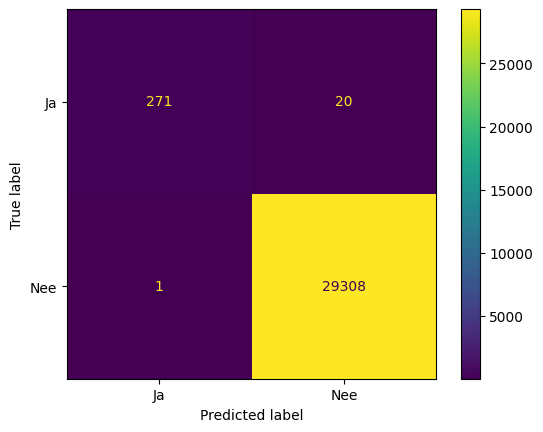

              precision    recall  f1-score   support

          Ja       1.00      0.93      0.96       291
         Nee       1.00      1.00      1.00     29309

    accuracy                           1.00     29600
   macro avg       1.00      0.97      0.98     29600
weighted avg       1.00      1.00      1.00     29600



In [15]:
# Ngram 2 Stopwords kept
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), lowercase=True, token_pattern=r"(?u)\b\w\w+\b|\+|\-")),
    ('clf', SGDClassifier(early_stopping=True, n_iter_no_change=5, validation_fraction = 0.25, verbose=3)),
])
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=parameter_grid, random_state=500, verbose=3, scoring='f1_macro')
random_search.fit(X_train, y_train)  
predicted_nb = random_search.predict(X_test)
print(np.mean(predicted_nb == y_test))
cm = confusion_matrix(y_test, predicted_nb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=random_search.classes_)
disp.plot()

plt.show()
print(metrics.classification_report(y_test, predicted_nb,
    target_names=random_search.classes_))

In [16]:
from pickle import dump

dump(random_search, open('best_models/best_drugs_ex2.pkl', 'wb'))